### 시계열 분석 (Auto ARIMA)
#### #01. 작업준비
패키지 참조

In [12]:
from pandas import read_excel, DataFrame, Series
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from pmdarima.arima import auto_arima
from datetime import timedelta
import seaborn as sb
import sys

In [13]:
df = read_excel("https://data.hossam.kr/E06/air_passengers.xlsx", index_col="Month")
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["axes.unicode_minus"] = False

#### #02. 데이터 분석
##### 처음부터 70%위치까지의 데이터
###### 분석모델 구축용(=학습용)

In [15]:
# 처음부터 70% 위치 전까지 분할
train = df[:int(0.7*len(df))]
train.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


검증용 데이터 (나머지30%)

In [16]:
# 70% 위치부터 끝까지 분할
test = df[int(0.7*len(df)):]
test.head()

,Passengers
Month,
1957-05-01,355
1957-06-01,422
1957-07-01,465
1957-08-01,467
1957-09-01,404


모델 구축
###### 시계열 데이터를 계절 ARIMA 모델에 맞추려고 할 때 첫 번째 목표는 측정항목을 최적화하는 ARIMA($p,d,q$)($P,D,Q$)M값을 찾는 것
###### M값을 고정한 상태에서 0부터 ($p,d,q$)($P,D,Q$)로 주어진 값의 범위 안에서 최적의 값을 검색한다.

In [17]:
my_p = 5    # 적절히 넉넉히
my_d = 2    # 차분 횟수 (검증한 결과를 활용)
my_q = 5    # 적절히 넉넉히
my_s=12     # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=train,                # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,              # p의 시작점
    max_p=my_p,                # p의 최대값
    d=my_d,                    # 차분 횟수
    start_q=0,              # q의 시작점
    max_q=my_q,                # q의 최대값
    seasonal=True,          # 계절성 사용 여부
    m=my_s,                    # 계절성 주기
    start_P=0,              # P의 시작점
    max_P=my_p,                # P의 최대값
    D=my_d,                    # 계절성 차분 횟수
    start_Q=0,              # Q의 시작점
    max_Q=my_q,                # Q의 최대값
    trace=True              # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=700.560, Time=0.03 sec


 ARIMA(1,2,0)(1,2,0)[12]             : AIC=628.108, Time=0.31 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=656.611, Time=0.04 sec
 ARIMA(1,2,0)(2,2,0)[12]             : AIC=618.256, Time=0.52 sec
 ARIMA(1,2,0)(3,2,0)[12]             : AIC=614.066, Time=0.94 sec
 ARIMA(1,2,0)(4,2,0)[12]             : AIC=609.992, Time=5.27 sec
 ARIMA(1,2,0)(5,2,0)[12]             : AIC=inf, Time=10.68 sec
 ARIMA(1,2,0)(4,2,1)[12]             : AIC=inf, Time=15.02 sec
 ARIMA(1,2,0)(3,2,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(1,2,0)(5,2,1)[12]             : AIC=inf, Time=12.36 sec
 ARIMA(0,2,0)(4,2,0)[12]             : AIC=651.167, Time=3.92 sec
 ARIMA(2,2,0)(4,2,0)[12]             : AIC=605.939, Time=5.31 sec
 ARIMA(2,2,0)(3,2,0)[12]             : AIC=606.557, Time=1.16 sec
 ARIMA(2,2,0)(5,2,0)[12]             : AIC=inf, Time=12.61 sec
 ARIMA(2,2,0)(4,2,1)[12]             : AIC=inf, Time=17.63 sec
 ARIMA(2,2,0)(3,2,1)[12]         

모델 학습
###### 관측치를 모델에 적제하여 학습을 수행한다.

In [18]:
model.fit(train)

ARIMA(order=(5, 2, 1), scoring_args={}, seasonal_order=(3, 2, 0, 12),
      suppress_warnings=True, with_intercept=False)

##### 잔차 플롯 검토
###### 왼쪽 상단 : 잔차 오차는 평균 0을 중심으로 변동하고 균일한 분산을 갖는 것으로 보임
###### 오른쪽 상단 : 밀도 도표는 평균이 0인 정규분포를 나타냄 
###### 왼쪽하단 : 모든 점이 빨간색 선과 완벽하게 일치해야 함, 편차가 크면 분포가 왜곡되었음을 의미한다.
###### 오른쪽 아래 : 상관관계도(ACF 플롯이라고도 함)는 잔차 오류가 자동 상관되지 않음을 보여줌. 모든 자기상관은 모델에서 설명되지 않는 잔차 오류에 일부 패턴이 있음을 의미하기 때문에 모델에 대해 더 많은 X(예측 변수)를 찾아야 함.

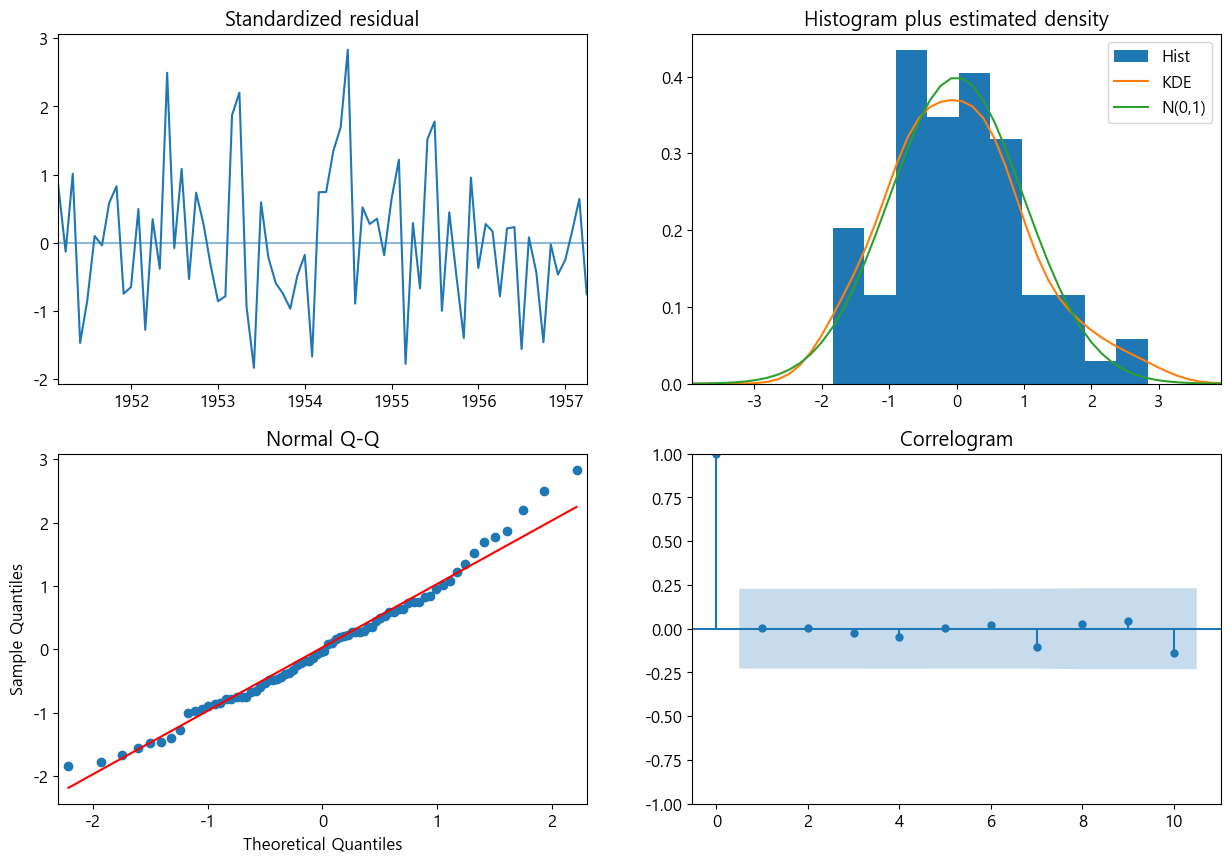

In [19]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

> ###### 전반적으로 잘 맞는 것 같음

예상치 생성
###### 학습결과를 토대로 주어진 n_periods 수 만큼의 이후 데이터를 예상하여 결과를 반환한다.

In [20]:
# 원본데이터 이후 10단계 까지 예측
y_predict = model.predict(n_periods=int(len(test)*10))
y_predict

1957-05-01      353.002624
1957-06-01      404.406024
1957-07-01      458.203716
1957-08-01      438.691228
1957-09-01      388.087040
                  ...     
1993-08-01   -38138.299543
1993-09-01   -38634.006049
1993-10-01   -39251.294567
1993-11-01   -39694.210917
1993-12-01   -39776.727334
Freq: MS, Length: 440, dtype: float64

관측치와 예상치 비교

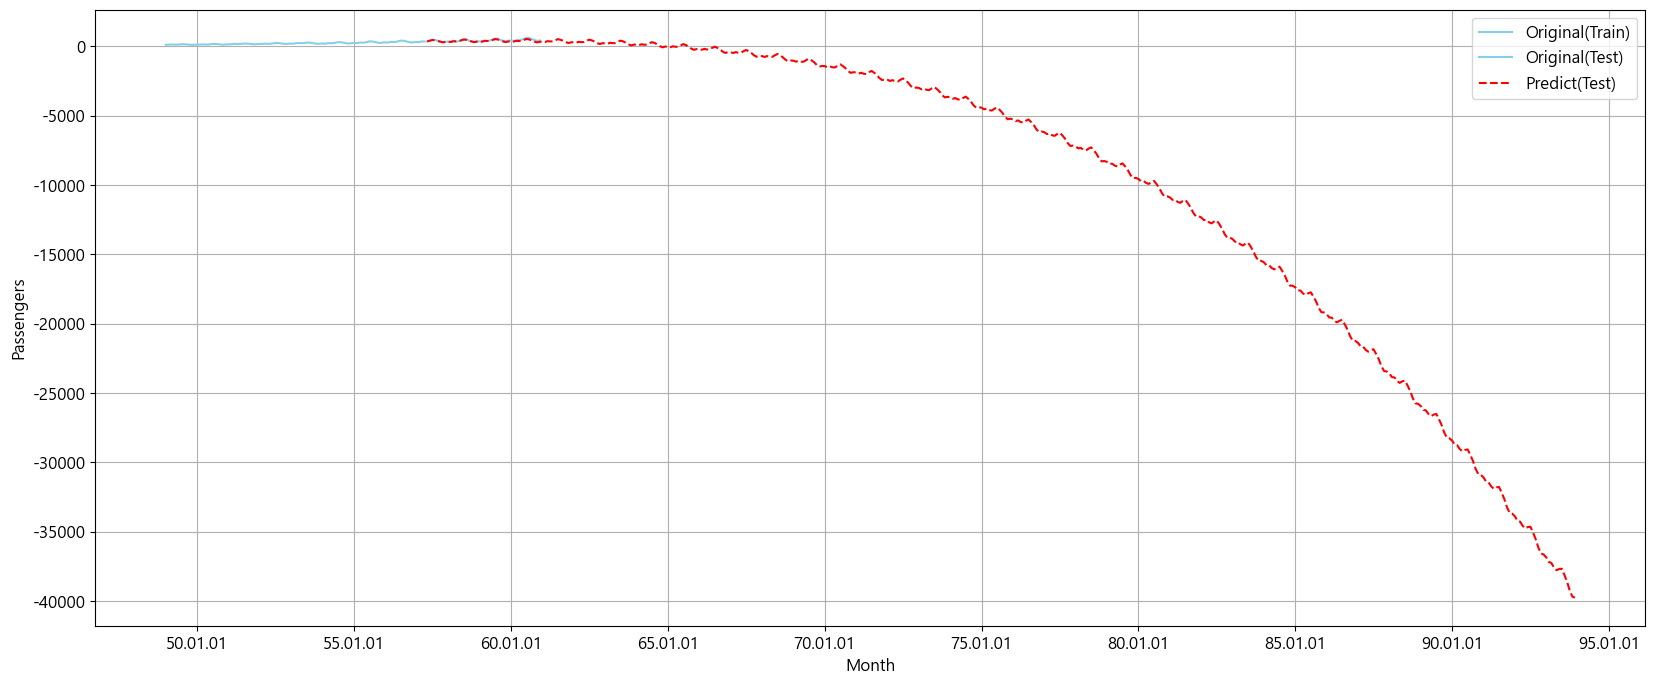

In [23]:
plt.figure(figsize=(20,8))

# 앞 70%의 원본 데이터
sb.lineplot(data=train, x=train.index, y='Passengers', label='Original(Train)', color='skyblue')

# 뒤 30%의 원본 데이터
sb.lineplot(data=test, x=test.index, y='Passengers', label='Original(Test)', color='skyblue')

# 뒤 30% + 10단계에 대한 예측 데이터
sb.lineplot(x=y_predict.index, y=y_predict.values, label='Predict(Test)', linestyle='--', color='red')

plt.xlabel('Month')
plt.ylabel('Passengers')

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()